In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from rlgym.policy import Policy

plt.style.use("bmh")


In [2]:
# env_name = "Pendulum-v1"
# env_name = "LunarLander-v2"
# env_name = "LunarLanderContinuous-v2"
env_name = "CartPole-v1"
env = gym.make(env_name, new_step_api=True)
n_episode = 400
log_every_n = n_episode / 100
x = np.arange(0, n_episode, log_every_n)


def train(algo, learning_rate, hidden_size, number_of_layers):

    obversation_space = env.observation_space.shape[0]
    action_space = env.action_space
    action_space_type = type(env.action_space).__name__.lower()

    if action_space_type == "discrete":
        is_continuous = False
    elif action_space_type == "box":
        is_continuous = True
    else:
        raise Exception("Unvalid type of action_space")

    policy = Policy(algo, obversation_space, action_space, is_continuous,
                    learning_rate, hidden_size, number_of_layers)

    log_rewards = []

    for t in tqdm(range(n_episode)):

        current_state = env.reset()
        next_state = None
        states, actions, next_states, rewards, flags, logprobs = [], [], [], [], [], []
        terminated, truncated = False, False

        while not terminated and not truncated:
            action, log_prob = policy.get_action(current_state)

            if is_continuous:
                action = np.array(action, ndmin=1)

            next_state, reward, terminated, truncated, _ = env.step(action)

            states.append(current_state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            flags.append(int(terminated))
            logprobs.append(log_prob)

            current_state = next_state

        policy.update_policy({
            "states":
            torch.from_numpy(np.array(states)).to(torch.device("cuda")),
            "actions":
            torch.from_numpy(np.array(actions)).to(torch.device("cuda")),
            "next_states":
            torch.from_numpy(np.array(next_states)).to(torch.device("cuda")),
            "rewards":
            torch.from_numpy(np.array(rewards)).to(torch.device("cuda")),
            "flags":
            torch.from_numpy(np.array(flags)).to(torch.device("cuda")),
            "logprobs":
            torch.stack(logprobs).squeeze()
        })

        if not t % log_every_n:
            log_rewards.append(np.sum(rewards))

    # policy.save("model-" + env_name + "-" + algo + ".pt")

    return log_rewards


In [3]:
log_rewards = train(algo="reinforce",
                    learning_rate=3e-3,
                    hidden_size=64,
                    number_of_layers=3)


100%|██████████| 400/400 [01:02<00:00,  6.41it/s]


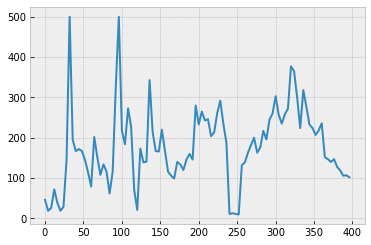

In [4]:
plt.plot(x, log_rewards)
plt.show()

In [5]:
log_rewards = train(algo="reinforce",
                    learning_rate=1e-3,
                    hidden_size=64,
                    number_of_layers=3)

100%|██████████| 400/400 [01:13<00:00,  5.44it/s]


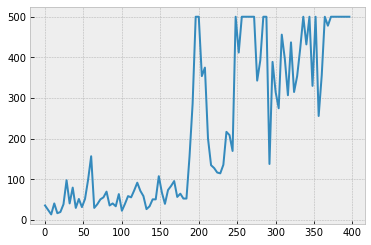

In [6]:
plt.plot(x, log_rewards)
plt.show()

In [7]:
log_rewards = train(algo="reinforce",
                    learning_rate=3e-4,
                    hidden_size=64,
                    number_of_layers=3)

100%|██████████| 400/400 [00:45<00:00,  8.79it/s]


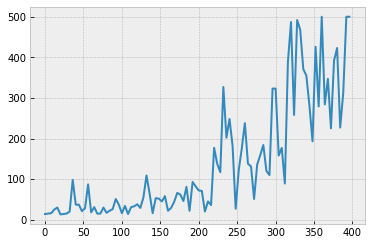

In [8]:
plt.plot(x, log_rewards)
plt.show()